In [1]:
import pandas as pd
import numpy as np
import pickle
import glob
import time
import seaborn as sns
from tqdm import tqdm
import matplotlib.pyplot as plt
import pandas_profiling as pdp
import matplotlib.cm as cm

In [14]:
def diff_from_first_first_some_data_per_FlightRegime(df, features):
    """
    各エンジンの最初から5行の平均値でオフセットする
    """
    f_diff_from_first_some_data_per_FlightRegime = pd.DataFrame()
    for i, grp in tqdm(df.groupby('EngineID')):
        for fr in np.sort(df['Flight Regime'].unique()):
            grp_fr = grp[grp['Flight Regime'] == fr]
            diff_from_first_some_data_1engine = pd.DataFrame()
            for c in features:
#                 mean_first_some_data = grp_fr[grp_fr['lifespan'] < 100][c].mean()
                mean_first_some_data = grp_fr.iloc[0:5][c].mean()
                diff_from_first_some_data_1engine[c + '_diff_from_first_5_data'] = grp_fr[c] - mean_first_some_data
            f_diff_from_first_some_data_per_FlightRegime = pd.concat([f_diff_from_first_some_data_per_FlightRegime, 
                                                                      diff_from_first_some_data_1engine])

    return f_diff_from_first_some_data_per_FlightRegime

In [5]:
f_rolmean = pd.read_pickle('../features/train__201__rolling_mean_per_FlightRegime.pkl')
target = pd.read_pickle('../features/target__000__raw_data.pkl')

In [6]:
f_rolmean = pd.concat([f_rolmean, target[['Flight Regime', 'EngineID', 'EngineIndex', 'lifespan']]], axis=1)
features = [c for c in f_rolmean.columns if c not in ['Flight Regime', 'EngineID', 'EngineIndex', 'lifespan']]
f = diff_from_first_first_some_data_per_FlightRegime(f_rolmean, features)

100%|████████████████████████████████████████████████████████████████████████████████| 260/260 [02:58<00:00,  1.18it/s]


In [7]:
df_test = pd.read_pickle('../features/test__000__raw_data.pkl')
f_rolmean_test = pd.read_pickle('../features/test__201__rolling_mean_per_FlightRegime.pkl')
df_test = pd.concat([df_test, f_rolmean_test], axis=1)
f = diff_from_first_first_some_data_per_FlightRegime(df_test, features)

100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [01:10<00:00,  1.20it/s]


In [8]:
df_test = pd.concat([df_test, f], axis=1)

In [10]:
new_train = pd.concat([f_rolmean[['Flight Regime', 'EngineID', 'lifespan', 'EngineIndex']], f], axis=1)
f_rolmean30 = new_train.columns[new_train.columns.str.endswith('_rolling_mean_30_diff_from_first_5_data')]

In [15]:
def plot_trend_features(df, column, num):
    plt.figure(figsize=(11,8))
    for fr in np.sort(df['Flight Regime'].unique()):
        df_fr = df[df['Flight Regime'] == fr]
        diff_ser = pd.Series()
        for i, grp in df_fr.groupby('EngineID'):
            plt.plot(grp['lifespan'], grp[column].diff(), 'o', c=cm.hsv(fr/6.0), zorder=0, alpha=0.5)
#             diff_ser = pd.concat([diff_ser, grp[grp['lifespan']<100][column].diff()])
#         per_low, per_high = np.percentile(diff_ser.fillna(diff_ser.mean()), [0,100])
#         per_low = diff_ser.min()
#         per_high = diff_ser.max()
#         plt.hlines(per_low*1.01, 0, 400)
#         plt.hlines(per_high*1.01, 0, 400)

    plt.xlabel('EngineIndex')
    plt.ylabel(str(num) + '_' + column)
    plt.show()

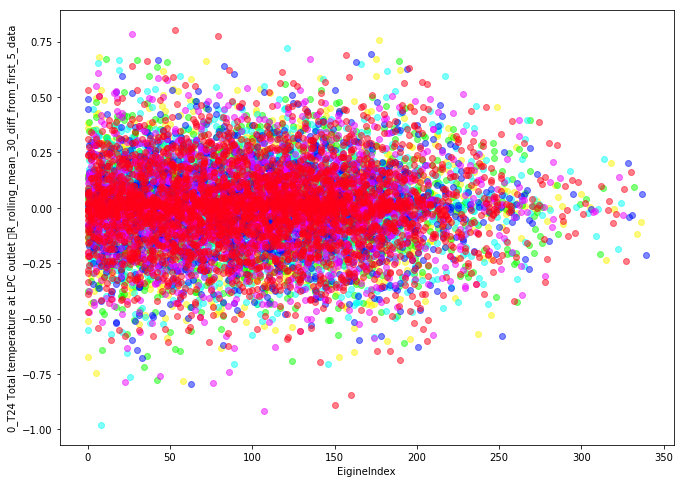

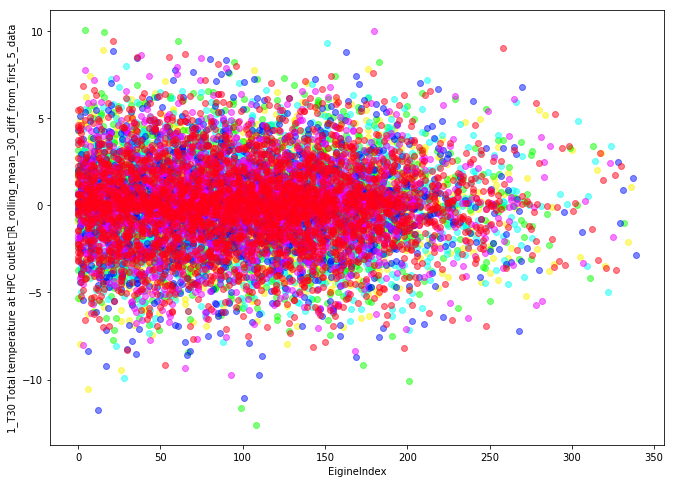

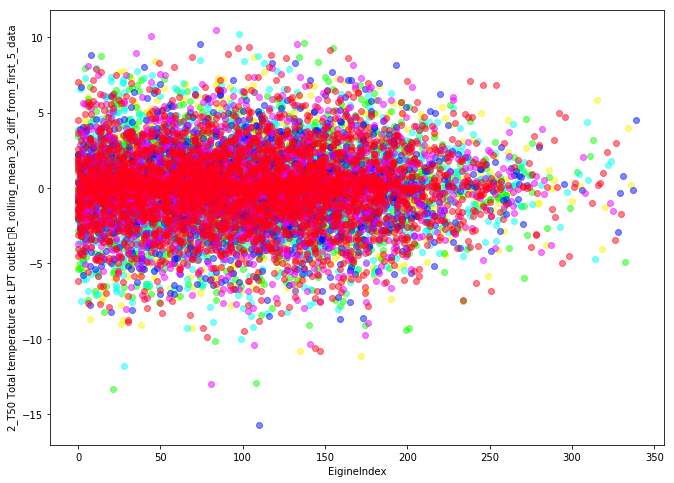

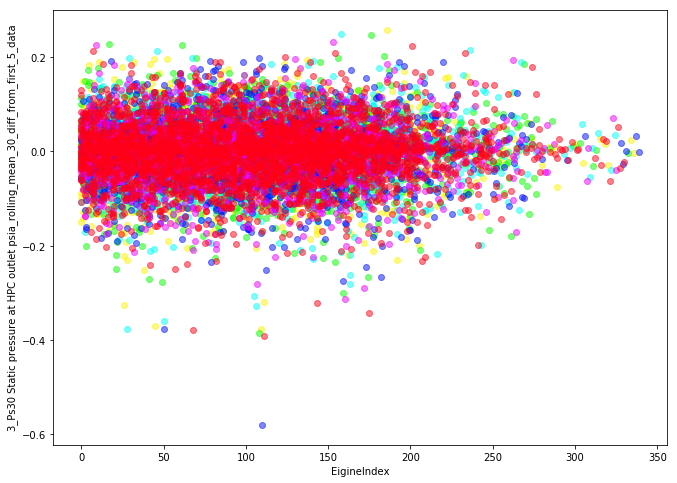

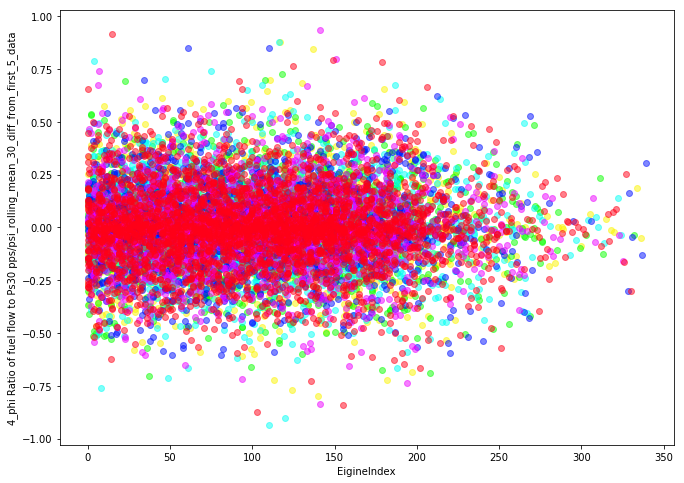

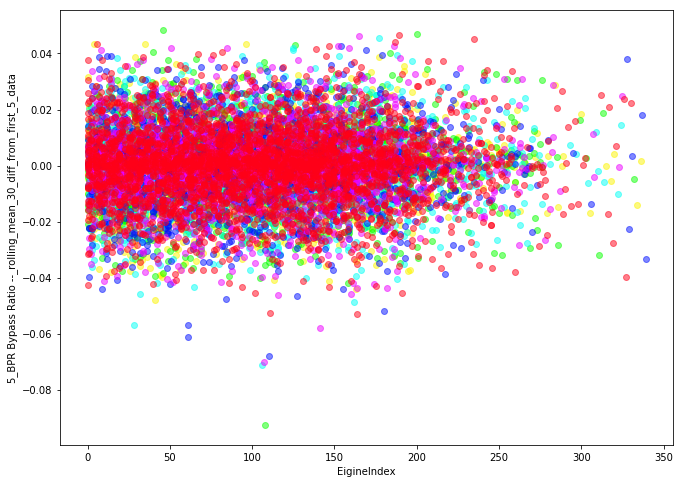

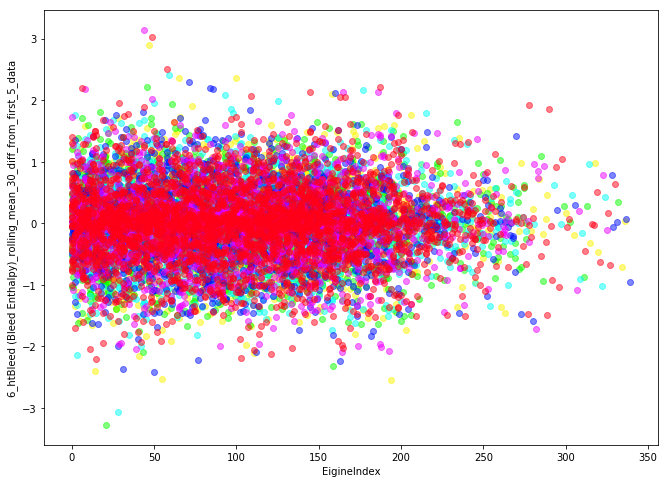

KeyboardInterrupt: 

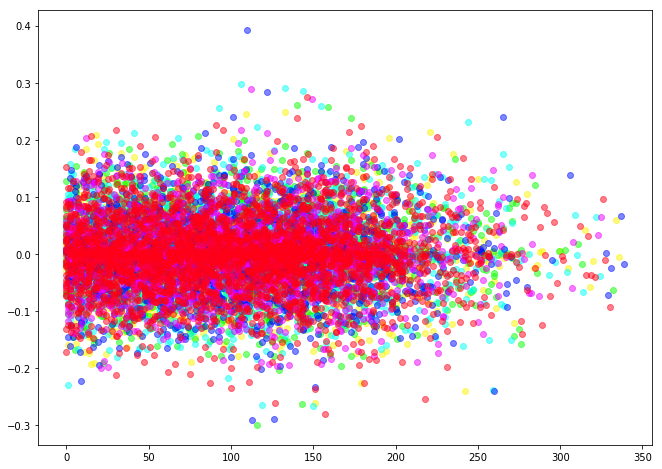

In [16]:
%%time
for (i, col) in enumerate(f_rolmean30):
    plot_trend_features(new_train, col, i)

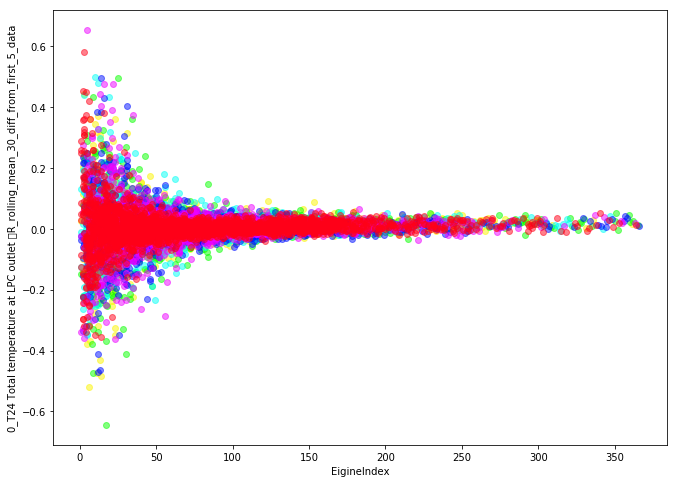

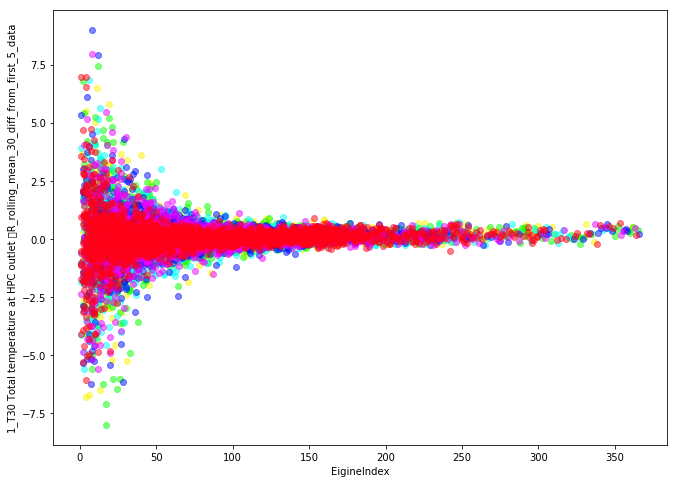

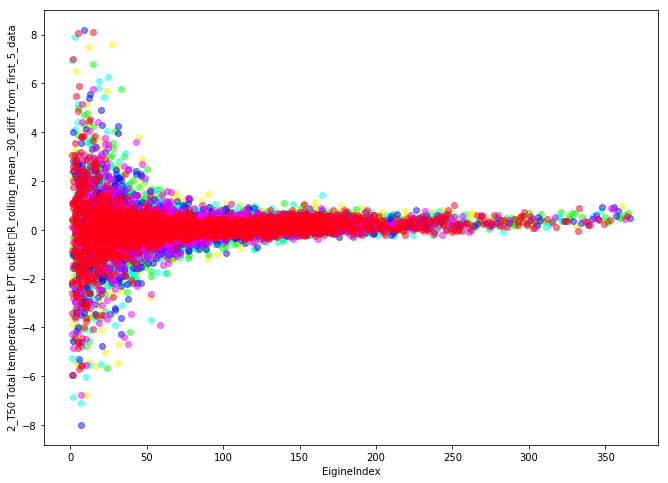

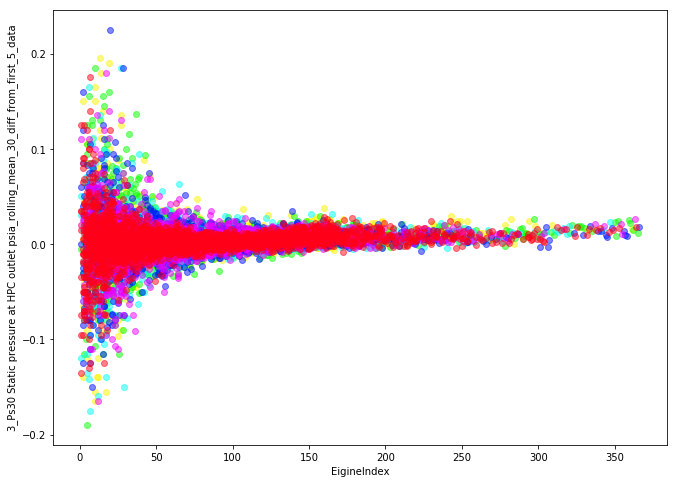

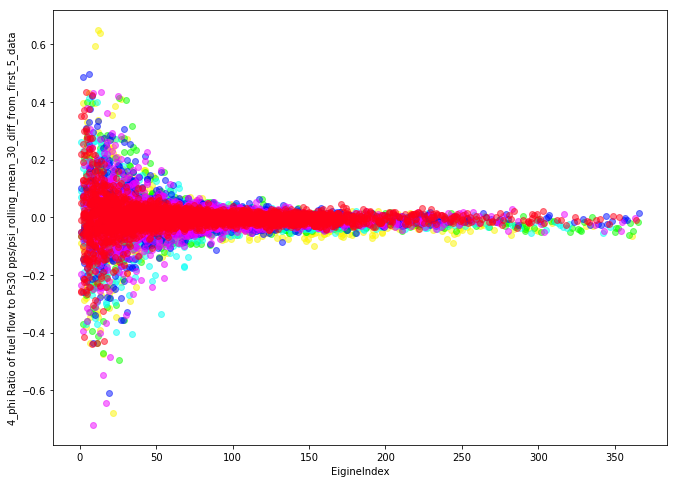

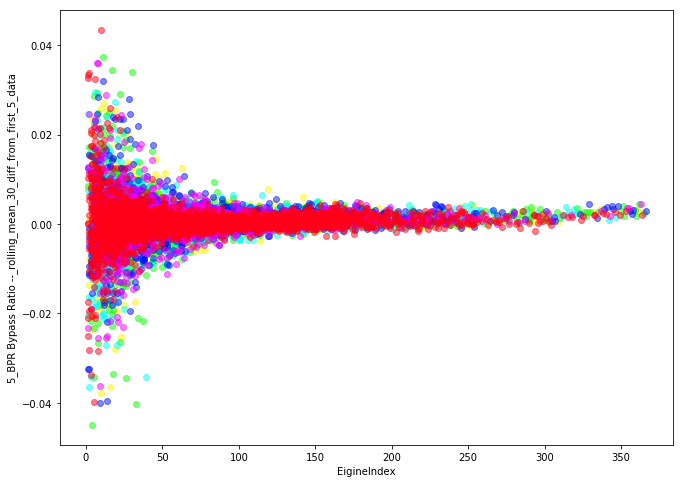

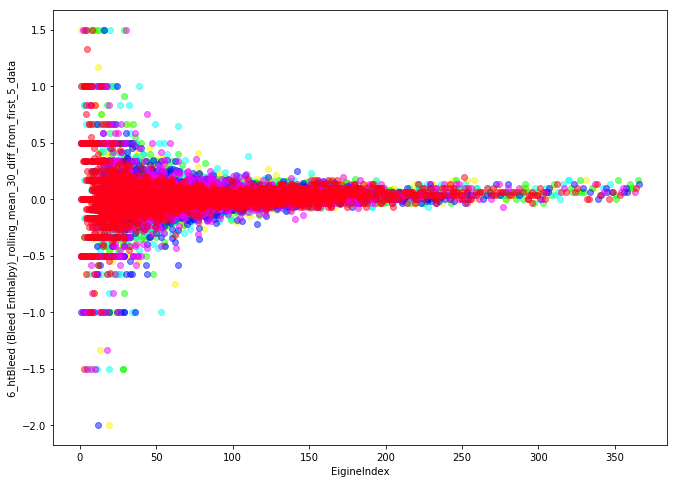

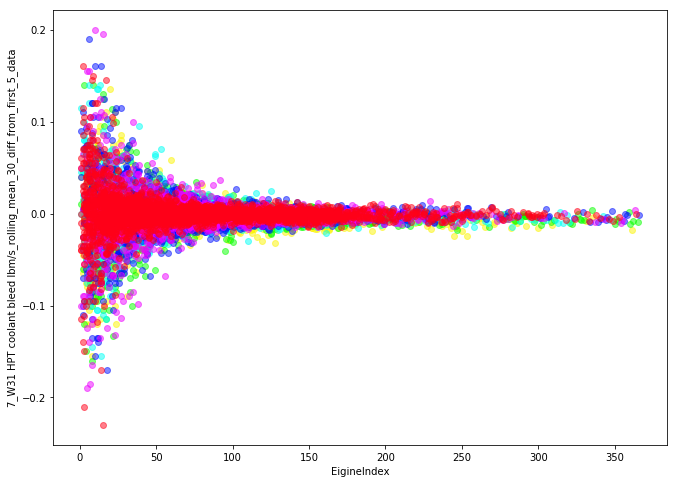

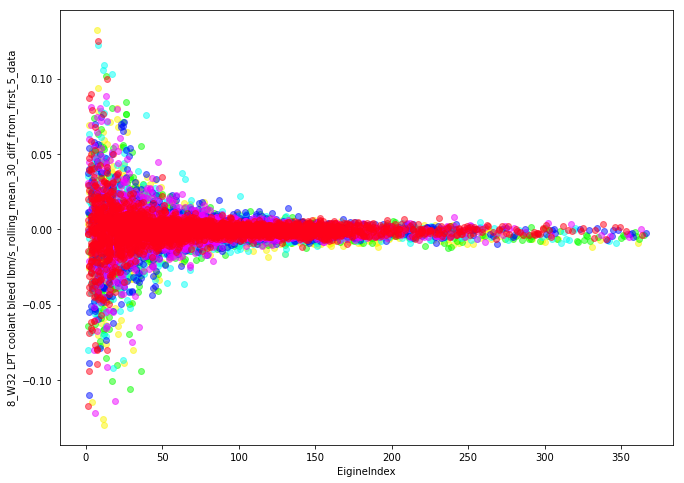

In [111]:
for (i, col) in enumerate(f_rolmean30):
    plot_trend_features(df_test, col, i)

100%|████████████████████████████████████████████████████████████████████████████████| 260/260 [00:22<00:00, 10.11it/s]


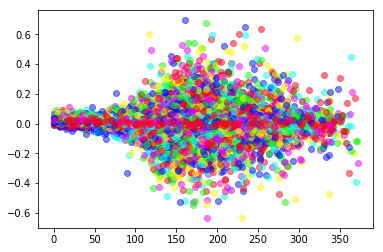

In [27]:
column = f_rolmean30[0]
df_diff = pd.DataFrame()
for i, grp in tqdm(new_train.groupby('EngineID')):
    diff_ser = pd.Series()
    for fr in np.sort(new_train['Flight Regime'].unique()):
        grp_fr = grp[grp['Flight Regime'] == fr]
        plt.plot(grp_fr['lifespan'], grp_fr[column].diff(), 'o', c=cm.hsv(fr/6.0), zorder=0, alpha=0.5)
        diff_ser = pd.concat([diff_ser, grp_fr[column].diff()])
    df_diff = pd.concat([df_diff, diff_ser.rolling(10).max()])
    

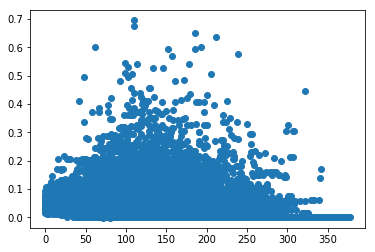

In [28]:
df_f = pd.concat([target, df_diff], axis=1).fillna(0)
plt.plot(df_f['lifespan'], df_f[0], 'o')

100%|███████████████████████████████████████████████████████████████████████████████| 260/260 [00:02<00:00, 122.56it/s]


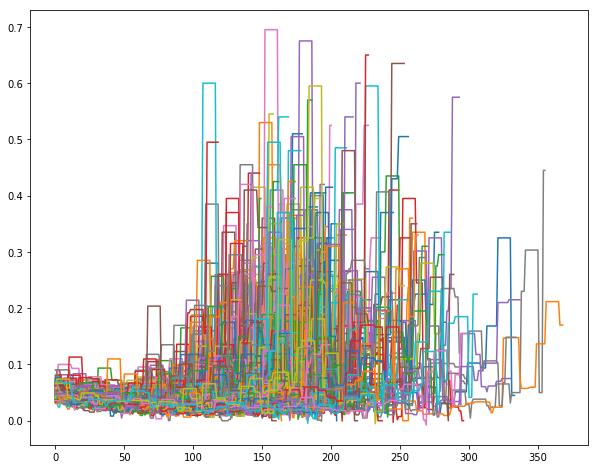

In [17]:
df_f = pd.concat([target[['Flight Regime', 'EngineID', 'EngineIndex', 'lifespan']],df_diff.fillna(0)], axis=1)
plt.figure(figsize=(10, 8))
for i, grp in tqdm(df_f.groupby('EngineID')):
    plt.plot(grp['lifespan'], grp[0].rolling(10).max())

In [255]:
def plot_trend_features_per_engine(df, column, engine_i):
    fig, axes = plt.subplots(ncols=2, sharex=True, figsize=(12,5))
    df = df[df['EngineID'] == df['EngineID'].unique()[engine_i]]
    for fr in np.sort(df['Flight Regime'].unique()):
        df_fr = df[df['Flight Regime'] == fr]
        for i, grp in df_fr.groupby('EngineID'):
            axes[0].plot(grp['EngineIndex'], grp[column].diff(), 'o', c=cm.hsv(fr/6.0))
            axes[1].plot(grp['EngineIndex'], grp[column].rolling(3).std(), 'o', c=cm.hsv(fr/6.0))
            
    plt.xlabel('EngineIndex')
    plt.ylabel(column)
    plt.xlim([0,400])
    plt.ylim([-4,4])
    plt.show()

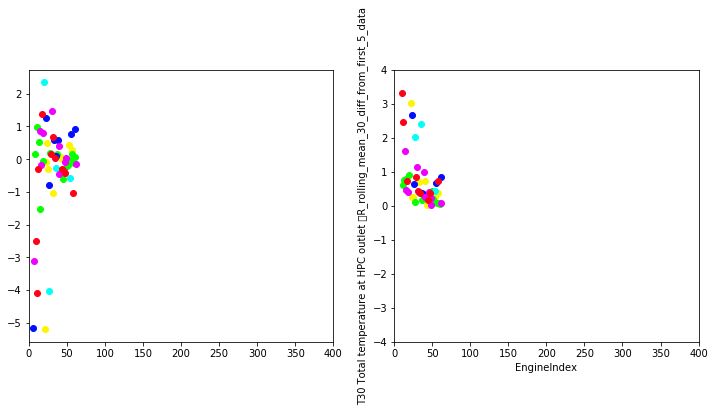

In [260]:
plot_trend_features_per_engine(df_test, f_rolmean30[1], 5)

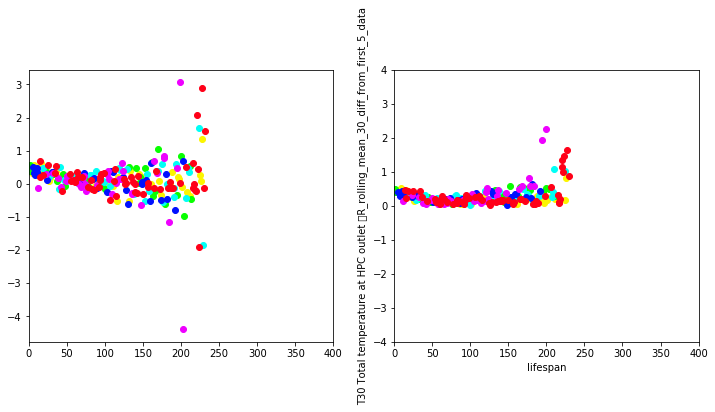

In [254]:
plot_trend_features_per_engine(new_train, f_rolmean30[1], 3)

In [9]:
f_rolmean30

Index(['T24 Total temperature at LPC outlet ｰR_rolling_mean_30_diff_from_first_5_data',
       'T30 Total temperature at HPC outlet ｰR_rolling_mean_30_diff_from_first_5_data',
       'T50 Total temperature at LPT outlet ｰR_rolling_mean_30_diff_from_first_5_data',
       'Ps30 Static pressure at HPC outlet psia_rolling_mean_30_diff_from_first_5_data',
       'phi Ratio of fuel flow to Ps30 pps/psi_rolling_mean_30_diff_from_first_5_data',
       'BPR Bypass Ratio --_rolling_mean_30_diff_from_first_5_data',
       'htBleed (Bleed Enthalpy)_rolling_mean_30_diff_from_first_5_data',
       'W31 HPT coolant bleed lbm/s_rolling_mean_30_diff_from_first_5_data',
       'W32 LPT coolant bleed lbm/s_rolling_mean_30_diff_from_first_5_data'],
      dtype='object')

In [284]:
def analize_outlier(df, column):
    for fr in np.sort(df['Flight Regime'].unique()):
        df_fr = df[df['Flight Regime'] == fr]
        diff_ser = pd.Series()
        for i, grp in df_fr.groupby('EngineID'):
            diff_ser = pd.concat([diff_ser, grp[grp['lifespan']<100][column].diff()])
        per_low, per_high = np.percentile(diff_ser.fillna(diff_ser.mean()), [0,100])
        print(per_high)
        for i, grp in df_fr.groupby('EngineID'):
            count_outlier_over100 = grp[((grp[column].diff() < per_low) | (grp[column].diff() > per_high)) &
                                        (grp['lifespan'] > 100)][column].count()
            count_outlier_under100 = grp[((grp[column].diff() < per_low) | (grp[column].diff() > per_high)) &
                                         (grp['lifespan'] < 100)][column].count()
            print('Flight Regime:', fr, ' EngineID:', i, 
                  ' outlier_over100', count_outlier_over100,' outlier_under100', count_outlier_under100,
                  ' len_over100:', len(grp[grp['lifespan']>100]), ' len_under100', len(grp[grp['lifespan']<100]))
        """
        df_test_fr = df_test[df_test['Flight Regime'] == fr]
        for i, grp in df_test_fr.groupby('EngineID'):
            plt.plot(grp['EngineID'], grp[column].diff(), linewidth=0.5, c=cm.hsv(fr/6.0), zorder=0)
        plt.hlines(per_low, 0, 360, color='k', zorder=1)
        plt.hlines(per_high, 0, 360, color='k', zorder=1)
        """

In [285]:
for col in f_rolmean30[0:1]:
    analize_outlier(new_train, col)

0.10833333333334849
Flight Regime: 1  EngineID: Train_Engine_001  outlier_over100 3  outlier_under100 0  len_over100: 7  len_under100 17
Flight Regime: 1  EngineID: Train_Engine_002  outlier_over100 1  outlier_under100 0  len_over100: 27  len_under100 11
Flight Regime: 1  EngineID: Train_Engine_003  outlier_over100 1  outlier_under100 0  len_over100: 8  len_under100 16
Flight Regime: 1  EngineID: Train_Engine_004  outlier_over100 1  outlier_under100 0  len_over100: 22  len_under100 16
Flight Regime: 1  EngineID: Train_Engine_005  outlier_over100 3  outlier_under100 0  len_over100: 5  len_under100 13
Flight Regime: 1  EngineID: Train_Engine_006  outlier_over100 2  outlier_under100 0  len_over100: 12  len_under100 16
Flight Regime: 1  EngineID: Train_Engine_007  outlier_over100 1  outlier_under100 0  len_over100: 9  len_under100 13
Flight Regime: 1  EngineID: Train_Engine_008  outlier_over100 2  outlier_under100 0  len_over100: 6  len_under100 16
Flight Regime: 1  EngineID: Train_Engine_

KeyboardInterrupt: 

Flight Regime 6 のとき特にoutlierが多い印象

In [ ]:
f_rolmean

In [319]:
new_train2 = new_train.copy()
new_train2 = new_train2[new_train2['Flight Regime'] == 1]
new_train2.loc[new_train2[f_rolmean30[0]].diff() > 0.108, f_rolmean30[0]] = np.nan

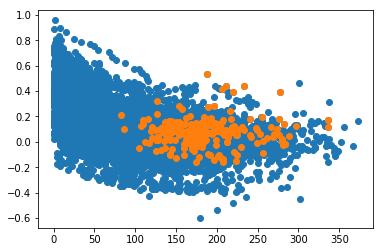

In [318]:
plt.plot(new_train2['lifespan'], new_train2[f_rolmean30[0]].interpolate(), 'o')
plt.plot(new_train2[new_train2[f_rolmean30[0]].diff() > 0.108]['lifespan'],
         new_train2[new_train2[f_rolmean30[0]].diff() > 0.108][f_rolmean30[0]], 'o')

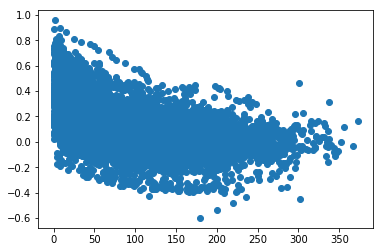

In [320]:
plt.plot(new_train2['lifespan'], new_train2[f_rolmean30[0]].interpolate(), 'o')
plt.plot(new_train2[new_train2[f_rolmean30[0]].diff() > 0.108][f_rolmean30[0]].interpolate(), 'o')

In [ ]:
def search_final_outlier_per_engine(df, column):
    for fr in np.sort(df['Flight Regime'].unique()):
        df_fr = df[df['Flight Regime'] == fr]
        diff_ser = pd.Series()
        for i, grp in df_fr.groupby('EngineID'):
            diff_ser = pd.concat([diff_ser, grp[grp['lifespan']<100][column].diff()])
        per_low, per_high = np.percentile(diff_ser.fillna(diff_ser.mean()), [0,100])
        print(per_high)
        for i, grp in df_fr.groupby('EngineID'):
            count_outlier_over100 = grp[((grp[column].diff() < per_low) | (grp[column].diff() > per_high)) &
                                        (grp['lifespan'] > 100)][column].count()
            count_outlier_under100 = grp[((grp[column].diff() < per_low) | (grp[column].diff() > per_high)) &
                                         (grp['lifespan'] < 100)][column].count()
            print('Flight Regime:', fr, ' EngineID:', i, 
                  ' outlier_over100', count_outlier_over100,' outlier_under100', count_outlier_under100,
                  ' len_over100:', len(grp[grp['lifespan']>100]), ' len_under100', len(grp[grp['lifespan']<100]))
        """
        df_test_fr = df_test[df_test['Flight Regime'] == fr]
        for i, grp in df_test_fr.groupby('EngineID'):
            plt.plot(grp['EngineID'], grp[column].diff(), linewidth=0.5, c=cm.hsv(fr/6.0), zorder=0)
        plt.hlines(per_low, 0, 360, color='k', zorder=1)
        plt.hlines(per_high, 0, 360, color='k', zorder=1)
        """

lifespan 100以上or 100未満の分類問題として解くなら：このぎざぎざをうまく使いたい。  
- 直近XX個でdiffが閾値以上になった回数
- diff つっこむ  

寿命自体を予測する回帰を解くなら:このぎざぎざをうまくならしたい。  
- diffが閾値以上になった場合、異常値とみなして補間する。
- 最後の値が異常だったとき、どうやって補間できるんだろう。

In [140]:
new_train.head()

,Flight Regime,EngineID,lifespan,T24 Total temperature at LPC outlet ｰR_rolling_mean_3_diff_from_first_5_data,T24 Total temperature at LPC outlet ｰR_rolling_mean_5_diff_from_first_5_data,T24 Total temperature at LPC outlet ｰR_rolling_mean_10_diff_from_first_5_data,T24 Total temperature at LPC outlet ｰR_rolling_mean_20_diff_from_first_5_data,T24 Total temperature at LPC outlet ｰR_rolling_mean_30_diff_from_first_5_data,T30 Total temperature at HPC outlet ｰR_rolling_mean_3_diff_from_first_5_data,T30 Total temperature at HPC outlet ｰR_rolling_mean_5_diff_from_first_5_data,...,W31 HPT coolant bleed lbm/s_rolling_mean_3_diff_from_first_5_data,W31 HPT coolant bleed lbm/s_rolling_mean_5_diff_from_first_5_data,W31 HPT coolant bleed lbm/s_rolling_mean_10_diff_from_first_5_data,W31 HPT coolant bleed lbm/s_rolling_mean_20_diff_from_first_5_data,W31 HPT coolant bleed lbm/s_rolling_mean_30_diff_from_first_5_data,W32 LPT coolant bleed lbm/s_rolling_mean_3_diff_from_first_5_data,W32 LPT coolant bleed lbm/s_rolling_mean_5_diff_from_first_5_data,W32 LPT coolant bleed lbm/s_rolling_mean_10_diff_from_first_5_data,W32 LPT coolant bleed lbm/s_rolling_mean_20_diff_from_first_5_data,W32 LPT coolant bleed lbm/s_rolling_mean_30_diff_from_first_5_data
0,5,Train_Engine_001,148,-0.082000,-0.082167,-0.082167,-0.082167,-0.082167,-3.846667,-3.058333,...,-0.102333,-0.097067,-0.097067,-0.097067,-0.097067,-0.087603,-0.075158,-0.075158,-0.075158,-0.075158
1,6,Train_Engine_001,147,0.237000,0.199267,0.199267,0.199267,0.199267,1.406667,1.009667,...,-0.132000,-0.110700,-0.110700,-0.110700,-0.110700,-0.095120,-0.087690,-0.087690,-0.087690,-0.087690
2,4,Train_Engine_001,146,0.275333,0.214433,0.214433,0.214433,0.214433,-2.996667,-2.288000,...,-0.063000,-0.050867,-0.050867,-0.050867,-0.050867,0.071483,0.064597,0.064597,0.064597,0.064597
3,6,Train_Engine_001,145,0.042000,0.004267,0.004267,0.004267,0.004267,1.806667,1.409667,...,-0.042000,-0.020700,-0.020700,-0.020700,-0.020700,0.006680,0.014110,0.014110,0.014110,0.014110
4,4,Train_Engine_001,144,0.155333,0.094433,0.094433,0.094433,0.094433,-2.546667,-1.838000,...,-0.038000,-0.025867,-0.025867,-0.025867,-0.025867,-0.000367,-0.007253,-0.007253,-0.007253,-0.007253


In [144]:
f_count_outlier_per_FlightRegime = pd.DataFrame()
for fr in np.sort(new_train['Flight Regime'].unique()):
    grp_fr = grp[grp['Flight Regime'] == fr]
    count_outlier_1engine = pd.DataFrame()
    for c in f_rolmean30:
        per_low, per_high = np.percentile(grp_fr[c].fillna(0), [1, 99])
        print('Flight Regime', fr, ':', c, per_low, per_high )
            

Flight Regime 1 : T24 Total temperature at LPC outlet ｰR_rolling_mean_30_diff_from_first_5_data -0.08649999999999636 0.29553030303016153
Flight Regime 1 : T30 Total temperature at HPC outlet ｰR_rolling_mean_30_diff_from_first_5_data -1.4512666666670884 3.1114393939390834
Flight Regime 1 : T50 Total temperature at LPT outlet ｰR_rolling_mean_30_diff_from_first_5_data -0.9984666666663498 7.0723030303033045
Flight Regime 1 : Ps30 Static pressure at HPC outlet psia_rolling_mean_30_diff_from_first_5_data -0.06513333333333221 0.22675757575756908
Flight Regime 1 : phi Ratio of fuel flow to Ps30 pps/psi_rolling_mean_30_diff_from_first_5_data -0.862715151515048 0.18871666666666537
Flight Regime 1 : BPR Bypass Ratio --_rolling_mean_30_diff_from_first_5_data -0.014593666666665488 0.017266272727273498
Flight Regime 1 : htBleed (Bleed Enthalpy)_rolling_mean_30_diff_from_first_5_data -0.7266025641025698 0.5783333333333367
Flight Regime 1 : W31 HPT coolant bleed lbm/s_rolling_mean_30_diff_from_first_5

In [118]:
new_train['phi Ratio of fuel flow to Ps30 pps/psi_rolling_mean_30_diff_from_first_5_data'].diff().idxmax()

37834

In [122]:
def plot_hist(df, f):
    print(f)
    fig, axes = plt.subplots(ncols=2, sharex=True, figsize=(12,3))
    df[df['lifespan'] >=100 ][f].diff().hist(bins=100, ax=axes[0])
    df[df['lifespan'] <100 ][f].diff().hist(bins=100, ax=axes[1])
    plt.show()

T24 Total temperature at LPC outlet ｰR_rolling_mean_30_diff_from_first_5_data


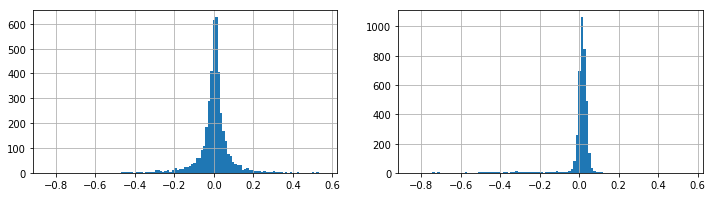

T30 Total temperature at HPC outlet ｰR_rolling_mean_30_diff_from_first_5_data


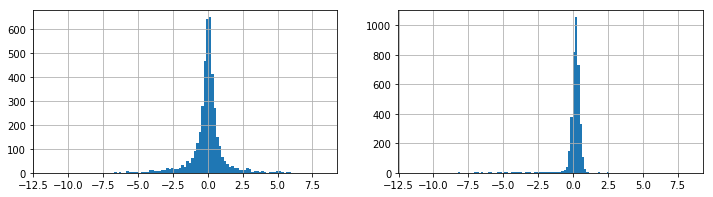

T50 Total temperature at LPT outlet ｰR_rolling_mean_30_diff_from_first_5_data


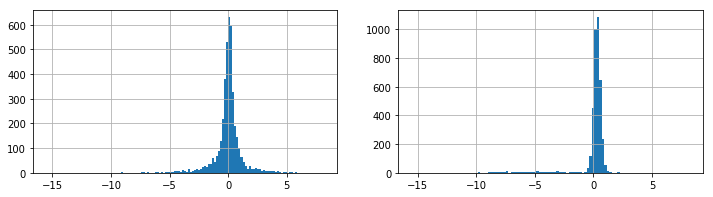

Ps30 Static pressure at HPC outlet psia_rolling_mean_30_diff_from_first_5_data


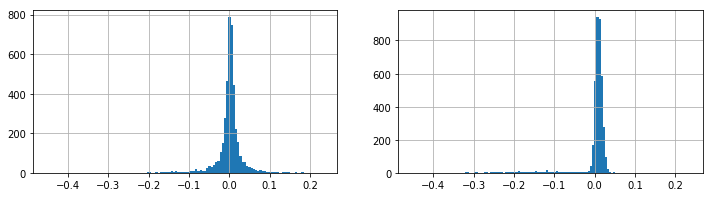

phi Ratio of fuel flow to Ps30 pps/psi_rolling_mean_30_diff_from_first_5_data


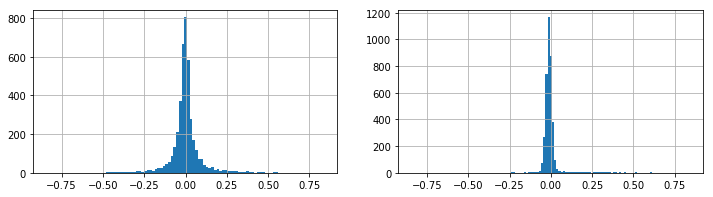

BPR Bypass Ratio --_rolling_mean_30_diff_from_first_5_data


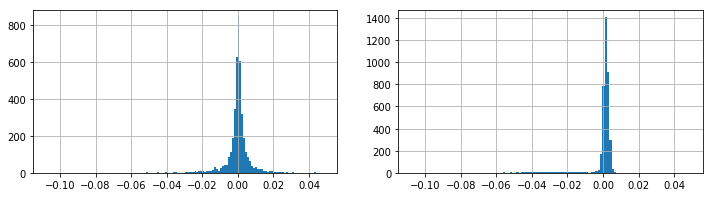

htBleed (Bleed Enthalpy)_rolling_mean_30_diff_from_first_5_data


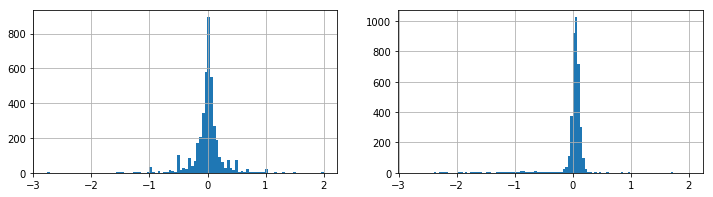

W31 HPT coolant bleed lbm/s_rolling_mean_30_diff_from_first_5_data


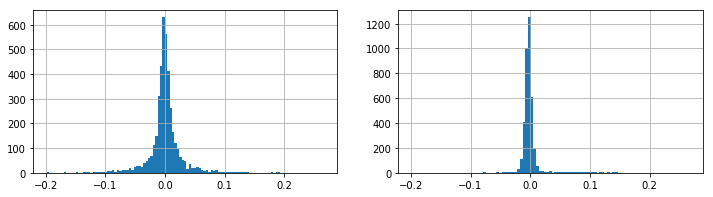

W32 LPT coolant bleed lbm/s_rolling_mean_30_diff_from_first_5_data


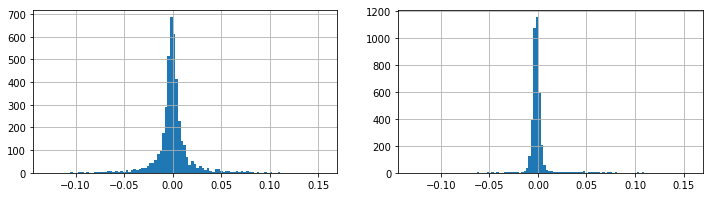

In [123]:
new_train_fr = new_train[new_train['Flight Regime'] == 5]
for f in f_rolmean30:
    plot_hist(new_train_fr, f)

In [83]:
def plot_hist(df, f):
    print(f)
    fig, axes = plt.subplots(ncols=2, sharex=True, figsize=(12,3))
    df[df['lifespan'] >=100 ][f].diff().hist(bins=100, ax=axes[0])
    df[df['lifespan'] <100 ][f].diff().hist(bins=100, ax=axes[1])
    plt.show()

T24 Total temperature at LPC outlet ｰR_rolling_mean_30_diff_from_first_5_data


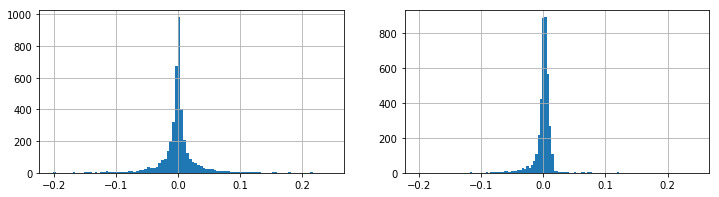

T30 Total temperature at HPC outlet ｰR_rolling_mean_30_diff_from_first_5_data


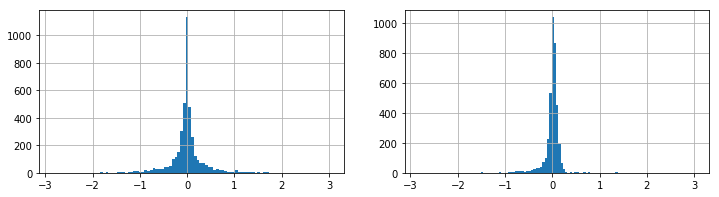

T50 Total temperature at LPT outlet ｰR_rolling_mean_30_diff_from_first_5_data


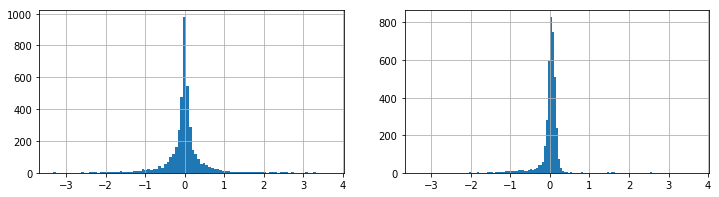

Ps30 Static pressure at HPC outlet psia_rolling_mean_30_diff_from_first_5_data


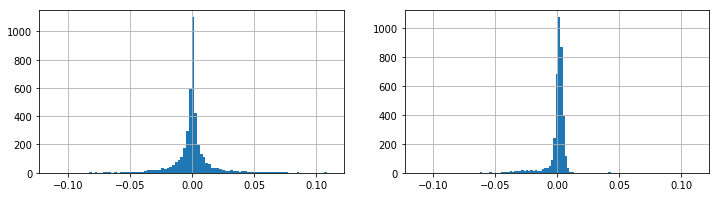

phi Ratio of fuel flow to Ps30 pps/psi_rolling_mean_30_diff_from_first_5_data


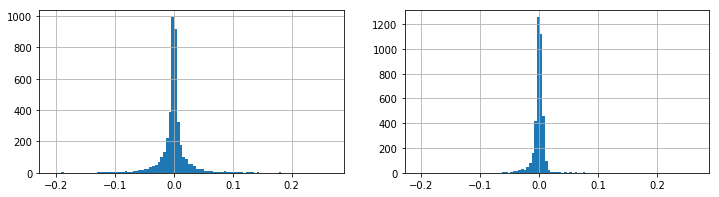

BPR Bypass Ratio --_rolling_mean_30_diff_from_first_5_data


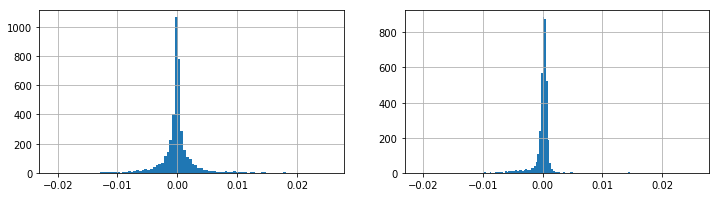

htBleed (Bleed Enthalpy)_rolling_mean_30_diff_from_first_5_data


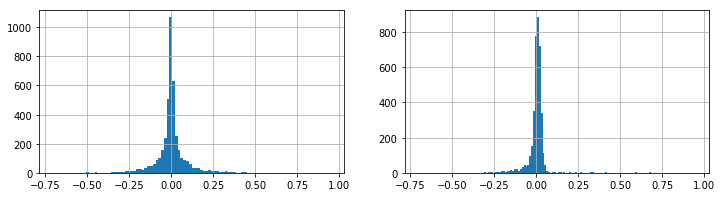

W31 HPT coolant bleed lbm/s_rolling_mean_30_diff_from_first_5_data


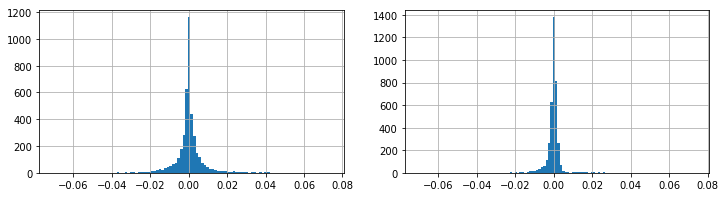

W32 LPT coolant bleed lbm/s_rolling_mean_30_diff_from_first_5_data


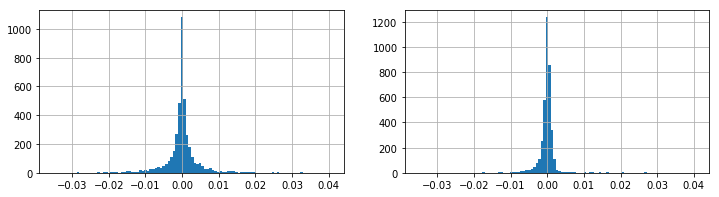

In [86]:
for col in f_rolmean30:
    plot_hist(new_train_fr, col)

In [33]:
df = pd.read_pickle('../features/train__203__agg_diff_from_first_some_data.pkl')

In [35]:
df.columns

Index(['T24 Total temperature at LPC outlet ｰR_rolling_mean_3_diff_from_first_5_data_rolling3std',
       'T24 Total temperature at LPC outlet ｰR_rolling_mean_3_diff_from_first_5_data_rolling10max',
       'T24 Total temperature at LPC outlet ｰR_rolling_mean_5_diff_from_first_5_data_rolling3std',
       'T24 Total temperature at LPC outlet ｰR_rolling_mean_5_diff_from_first_5_data_rolling10max',
       'T24 Total temperature at LPC outlet ｰR_rolling_mean_10_diff_from_first_5_data_rolling3std',
       'T24 Total temperature at LPC outlet ｰR_rolling_mean_10_diff_from_first_5_data_rolling10max',
       'T24 Total temperature at LPC outlet ｰR_rolling_mean_20_diff_from_first_5_data_rolling3std',
       'T24 Total temperature at LPC outlet ｰR_rolling_mean_20_diff_from_first_5_data_rolling10max',
       'T24 Total temperature at LPC outlet ｰR_rolling_mean_30_diff_from_first_5_data_rolling3std',
       'T24 Total temperature at LPC outlet ｰR_rolling_mean_30_diff_from_first_5_data_rolling10max',